<a href="https://colab.research.google.com/github/data-better/forecasting_class/blob/main/R_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 구글 Colab

* 구글 id가 있어야 이용 가능, 구글 drive 이용
* 텍스트와 코드로 구성 
  - 텍스트 작성 : 마크다운
  - 코드 수행 : Crtl+Enter, Shift+Enter, Alt+Enter 
* 크롬 브라우저에서 Python과 R을 실행 : R은 임시
  - 설치 필요하지 않음
  - GPU 무료 액세스
* Pyhon 기반 : https://colab.research.google.com/
* R : https://colab.research.google.com/notebook#create=true&language=r

In [12]:
library()

## 1. 이용할 패키지 불러오기
 * 예측관련 패키지 : forecast, mFilter
 * 시간이 좀 걸립니다.

In [45]:
install.packages(c('forecast', 'mFilter'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## 1. 데이터 읽기
  * KOSIS 또는 ECOS에서 데이터를 csv 형태로 내려받은 후 설명한 내용을 제거하고, 셀형식을 "," 없는 숫자로 전환하여 직사각형 형태로 저장
    - 여기서는 1970년- 2020년 분기 제조업 GDP, 서비스업 GDP, GDP 입니다.
    - github에 이미 정리 : https://github.com/data-better/forecasting_class/tree/main/data  
  * magrittr 패키지를 니용하면 %>% 의 파이프를 쓸 수 있습니다.(colab에 이미 설치)
    - head(log(gdp_ts)) 와 gdp_ts %>% log() %>% head()는 동일한 명령어

In [19]:
# GITHUB의 data 폴더의 csv를 지정하여 읽어옴

#  제조업 GDP, 서비스업 GDP, GDP  원계열
url_o = "https://raw.githubusercontent.com/data-better/forecasting_class/main/data/gdp_21.csv"
gdp_ts = url_o %>% read.csv() %>% ts(, start=1970, frequency=4)
gdp_ts %>% head()

,gdp_m,gdp_s,gdp
1970 Q1,1225.4,9632.0,15052.7
1970 Q2,1453.9,10191.9,18205.6
1970 Q3,1521.6,10494.1,17405.9
1970 Q4,1787.7,10444.1,21438.5
1971 Q1,1526.1,11051.6,16974.8
1971 Q2,1769.2,11564.6,20607.8


In [20]:
#  제조업 GDP, 서비스업 GDP, GDP  계절조정계열
url_sa = "https://raw.githubusercontent.com/data-better/forecasting_class/main/data/gdp_sa_21.csv"
gdp_sa_ts = url_sa %>% read.csv() %>% ts(, start=1970, frequency=4)
gdp_sa_ts %>% head()

,gdp_m_sa,gdp_s_sa,gdp_sa
1970 Q1,1358.9,9649.3,17109.7
1970 Q2,1440.9,10023.7,17797.7
1970 Q3,1503.6,10257.6,17907.8
1970 Q4,1685.2,10831.6,19287.5
1971 Q1,1672.8,11037.4,19395.7
1971 Q2,1747.5,11369.4,20027.5


In [21]:
# 그래프 크기 조정 옵션 등
options(warn=-1,repr.plot.width = 10, repr.plot.height = 6)

In [22]:
# 변수 선택
gdp = gdp_ts[,3]/1000
gdp_sa = gdp_sa_ts[,3]/1000

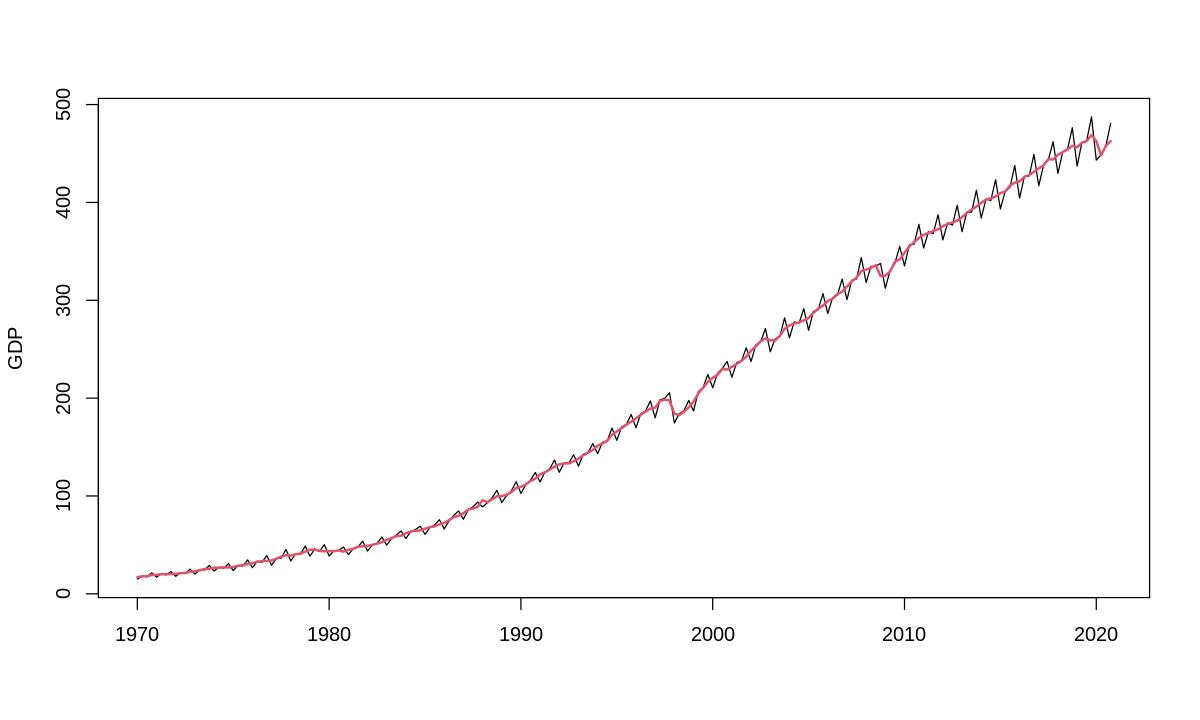

In [23]:
plot(gdp, xlab="", ylab="GDP" )
 lines(gdp_sa, col=2, lwd=2 )

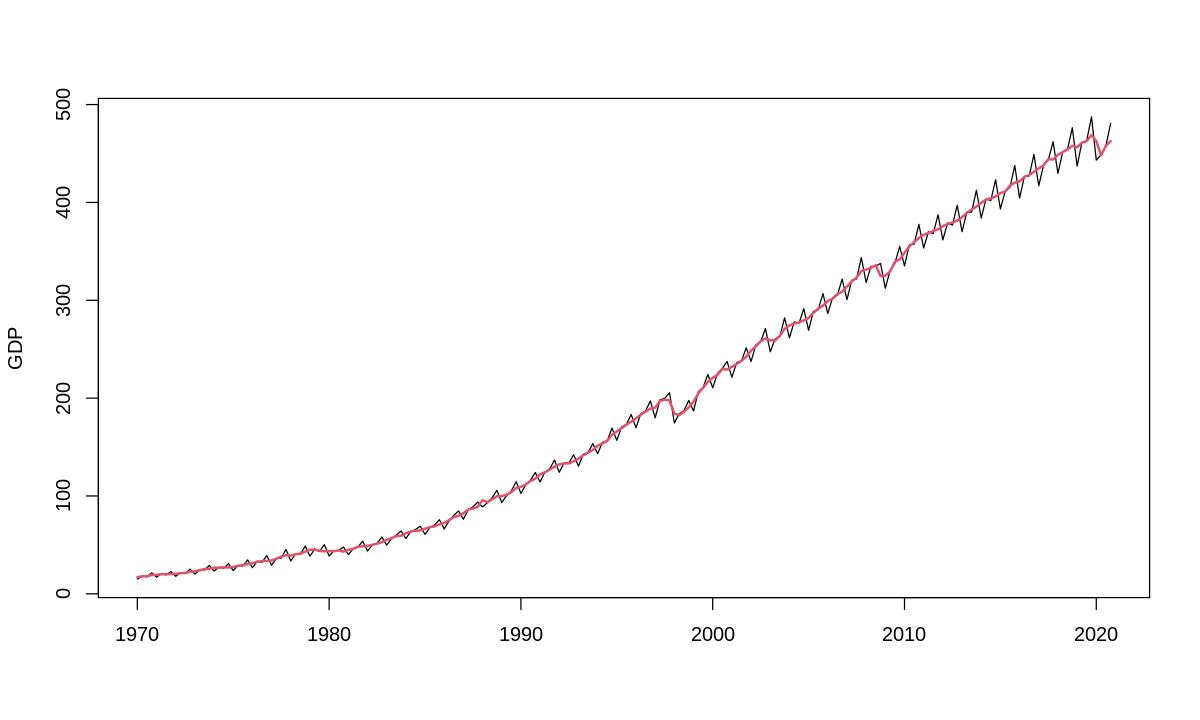

In [24]:
gdp %>% plot(xlab="", ylab="GDP" )
  gdp_sa %>% lines(col=2, lwd=2 )

## 3. 시계열의 탐색
   * 시계열도표로 패턴 파악
   * 스펙트럴 분석
   * 표본자기상관계수, 표본 부분자기상관계수

### (1) 시계열도표

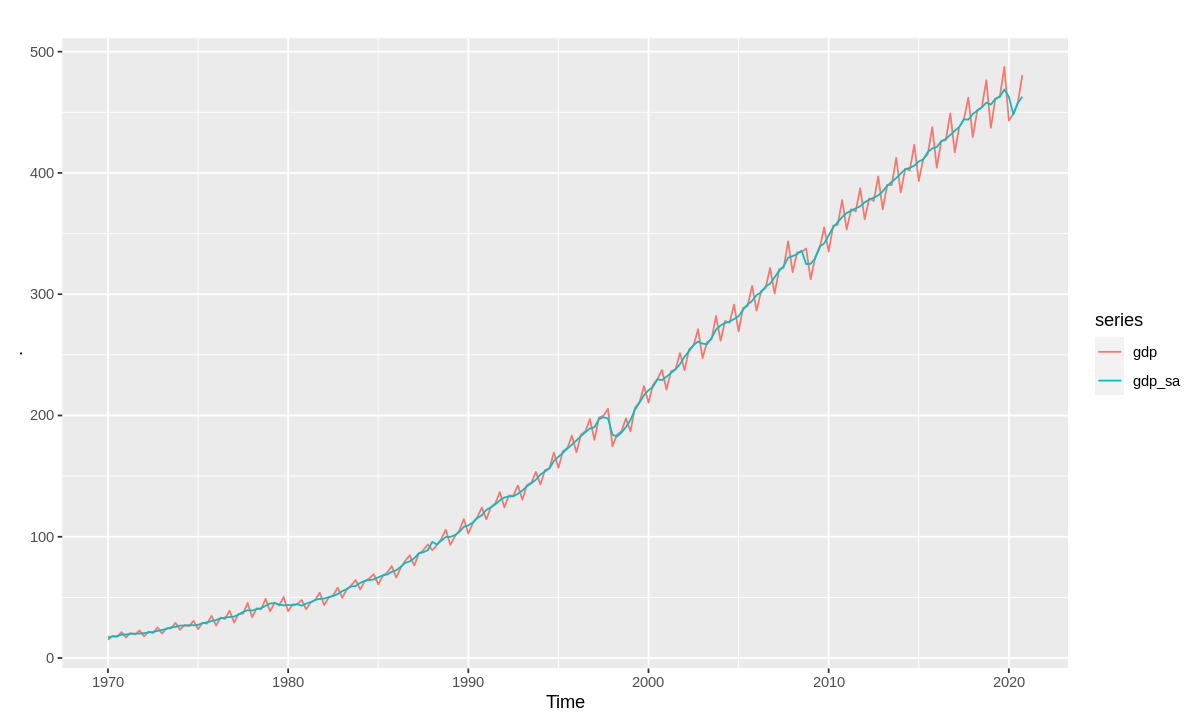

In [ ]:
cbind(gdp, gdp_sa) %>% autoplot()

 ### (2) 전기증감률과 로그차분의 비교

,Qtr1,Qtr2,Qtr3,Qtr4
2018,0.0056445661,0.0018865838,0.0016587550,0.0037234634
2019,0.0005782712,0.0051079212,0.0007030732,0.0085273831
2020,0.0082846598,0.0508049734,0.0224957770,0.0058808713


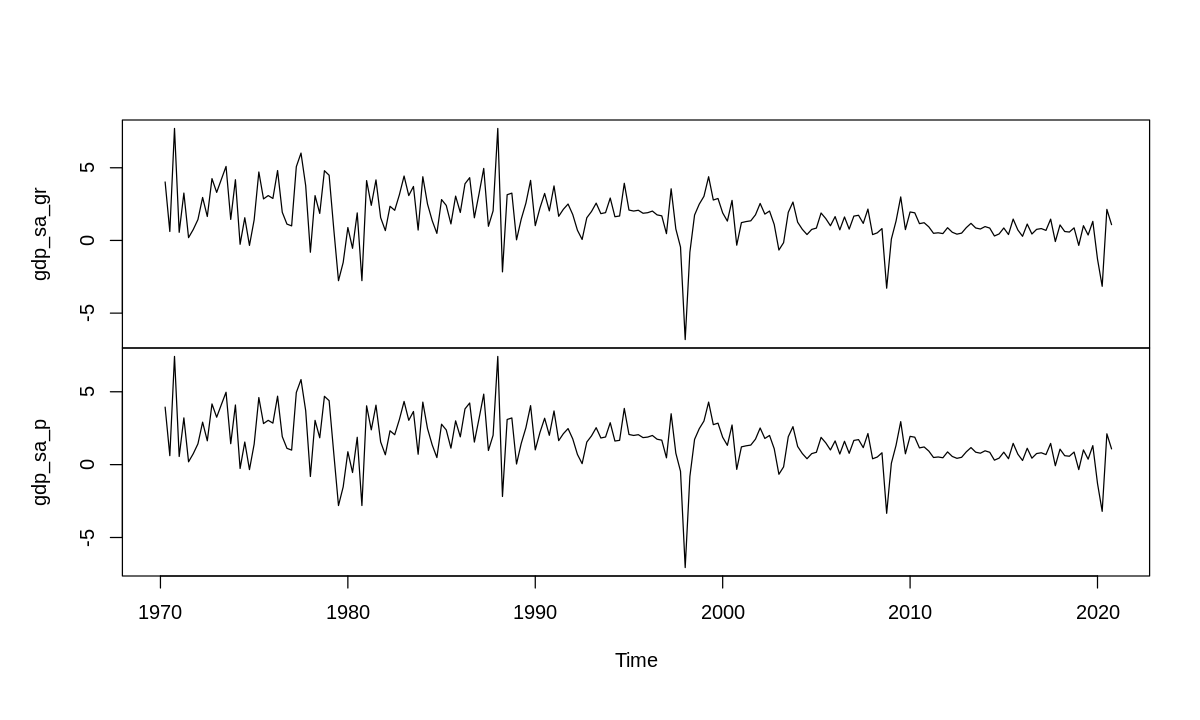

In [51]:
gdp_sa_gr = ts(c(NA, (gdp_sa-lag(gdp_sa,-1))/lag(gdp_sa,-1)*100),  start=1970, frequency=4)
gdp_sa_p  = diff(log(gdp_sa))*100
plot(cbind(gdp_sa_gr, gdp_sa_p), main="")
gdp_sa_gr - gdp_sa_p %>% tail(12)

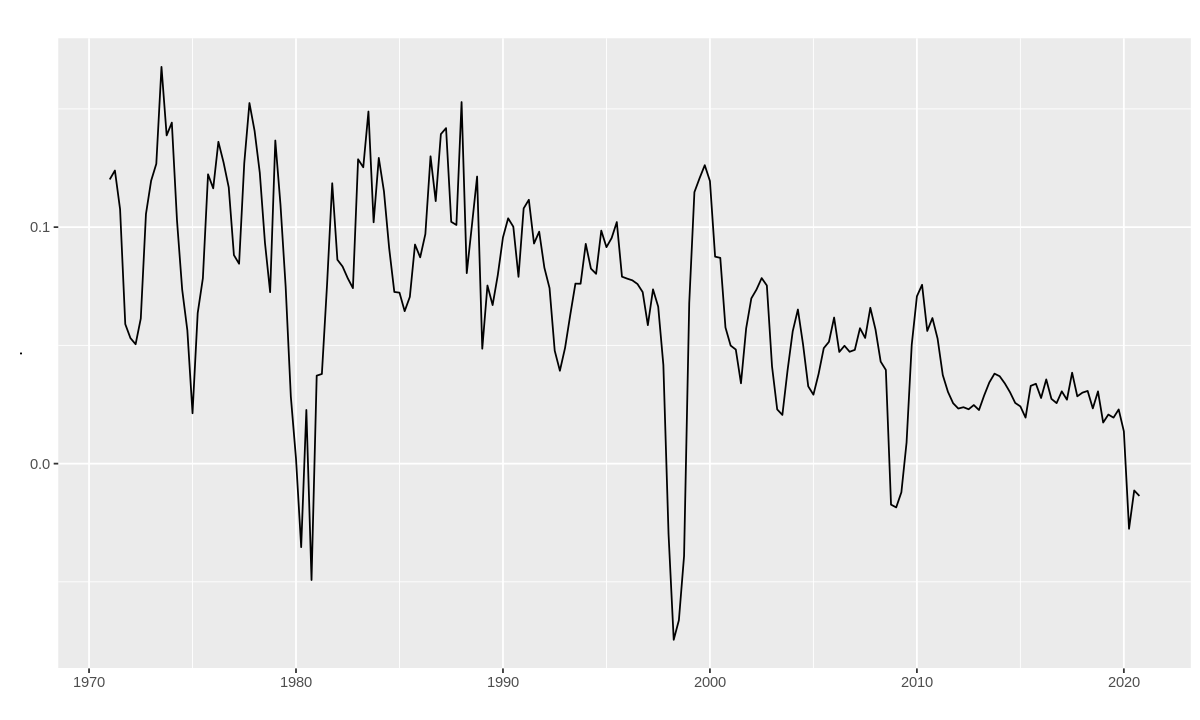

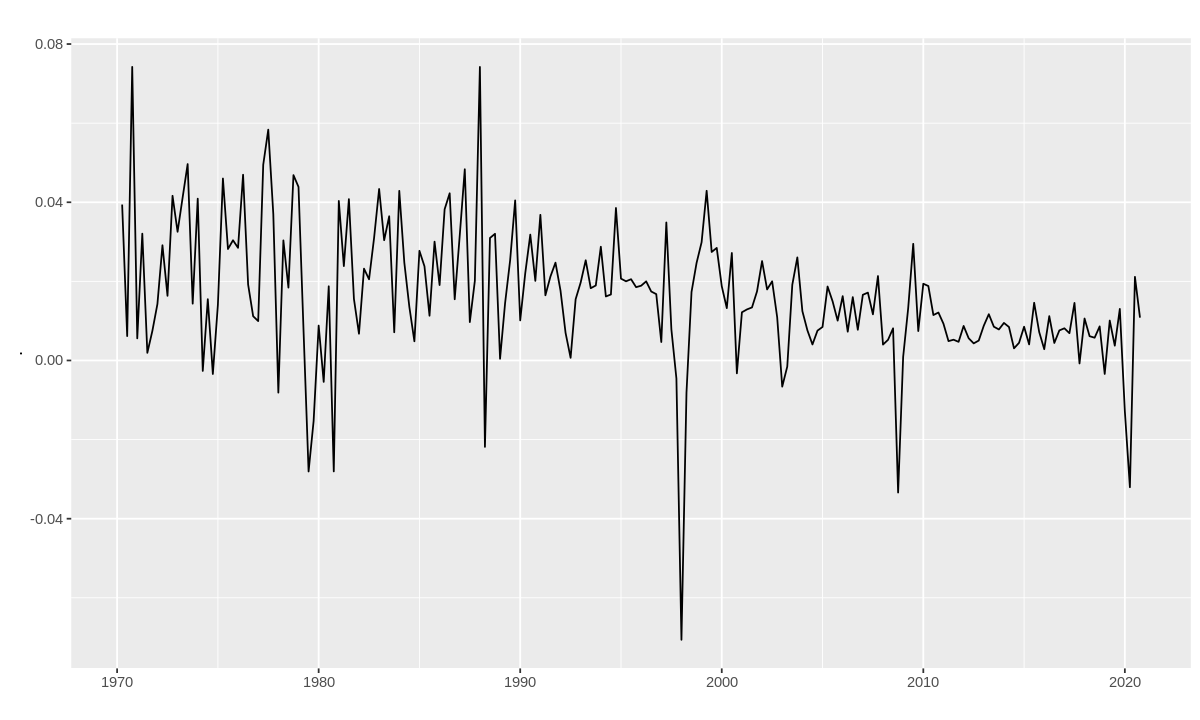

In [52]:
gdp %>% log() %>% diff(lag=4) %>% autoplot(xlab="")
gdp_sa %>% log() %>% diff() %>% autoplot(xlab="")

### (3) 스펙트럴 분석
* 주기적 시계열의 분석

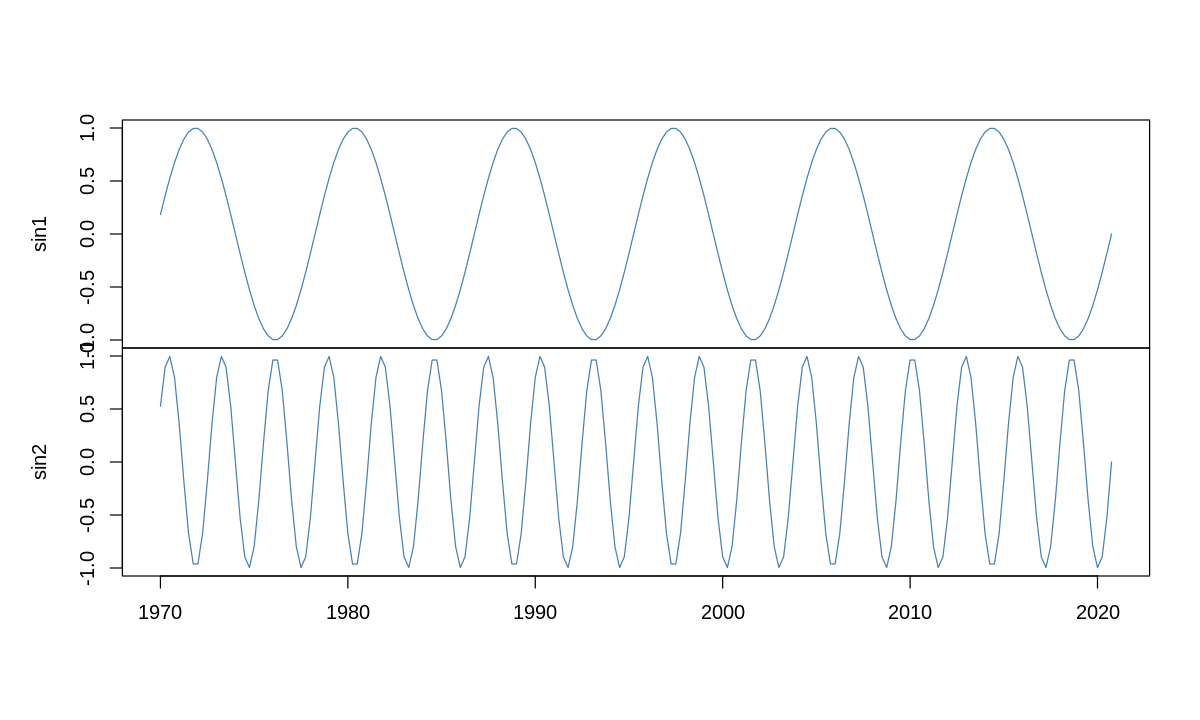

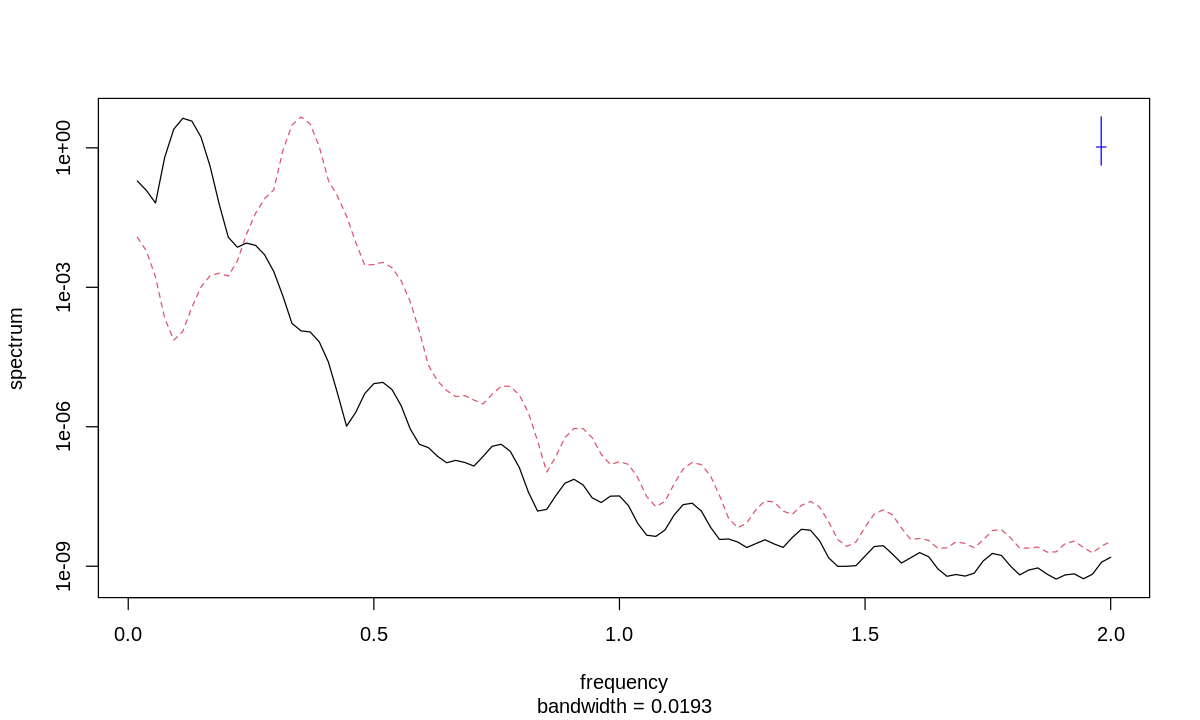

In [40]:
nn = gdp %>% length()
sin1 = sin(1:nn/nn*12*pi) %>% ts(start=1970, frequency=4)
sin2 = sin(1:nn/nn*36*pi) %>% ts(start=1970, frequency=4)
plot(cbind(sin1, sin2), main="", xlab="", ylab="", col="steelblue")
spectrum(cbind(sin1, sin2), spans=c(3,3), main="", col=1:2)

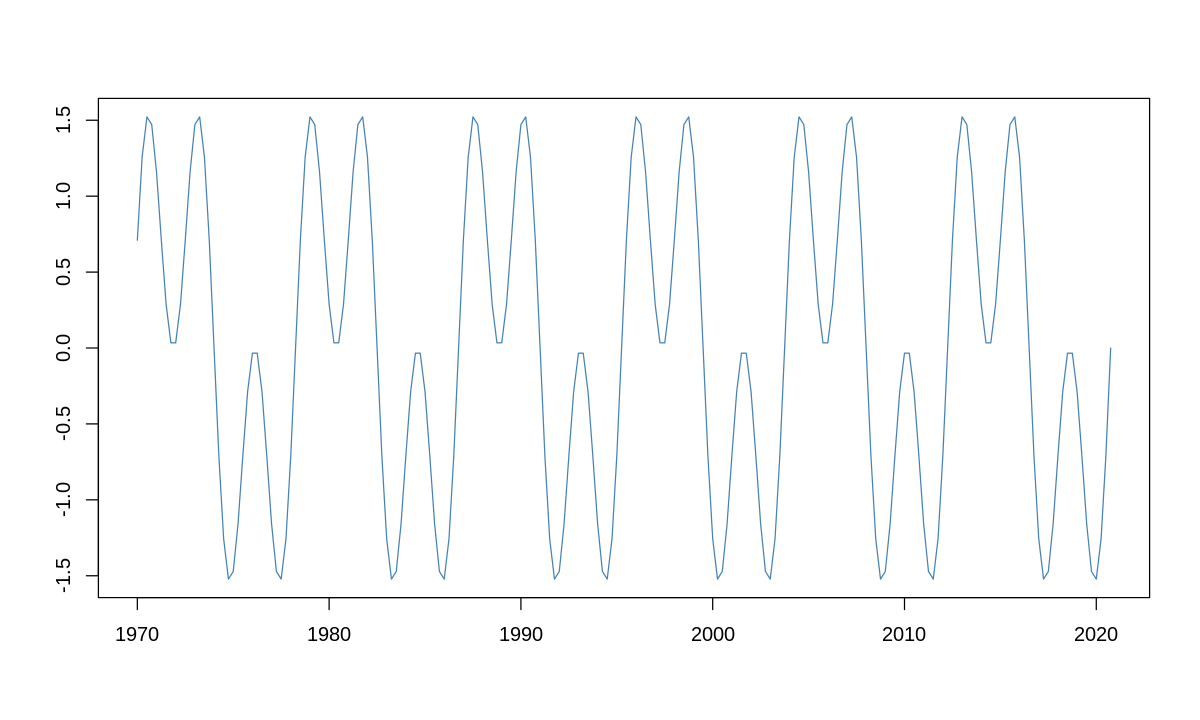

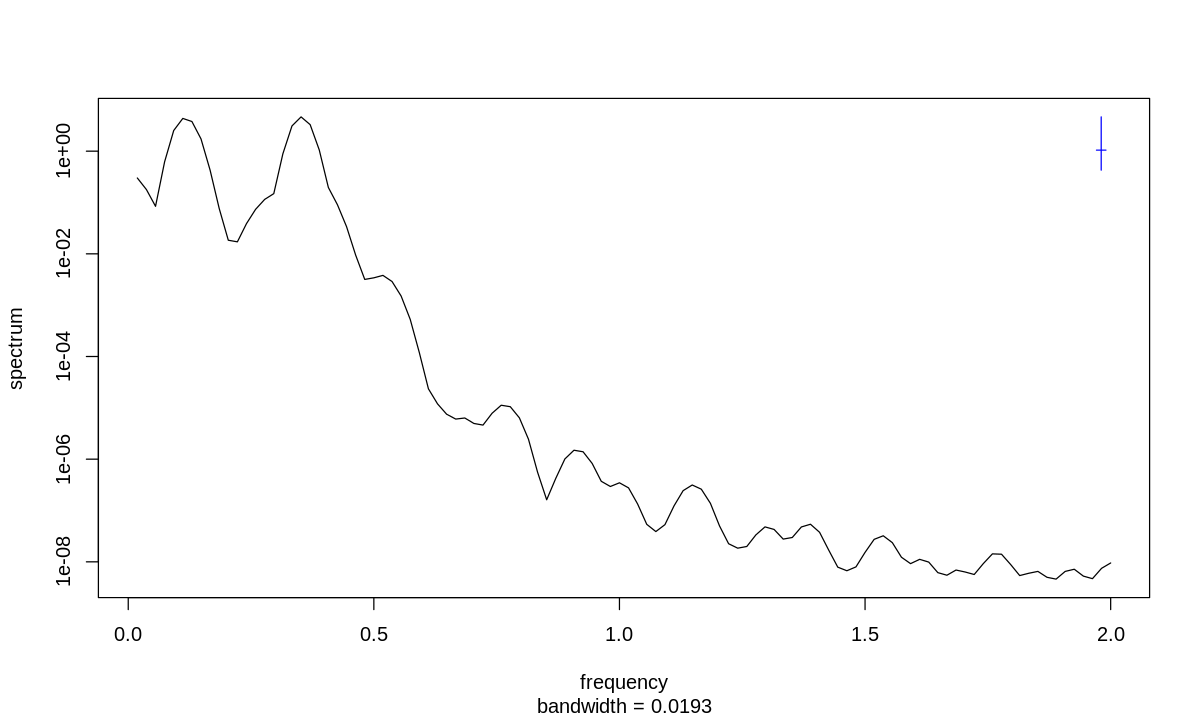

In [42]:
plot(sin1+sin2, main="", xlab="", ylab="", col="steelblue")
spectrum(sin1+sin2, spans=c(3,3), main="", col=1)

### (4) GDP와 계절조정 GDP의 스펙트럼
 * 원계열은 계절 빈도수에서 큰 값을 보임

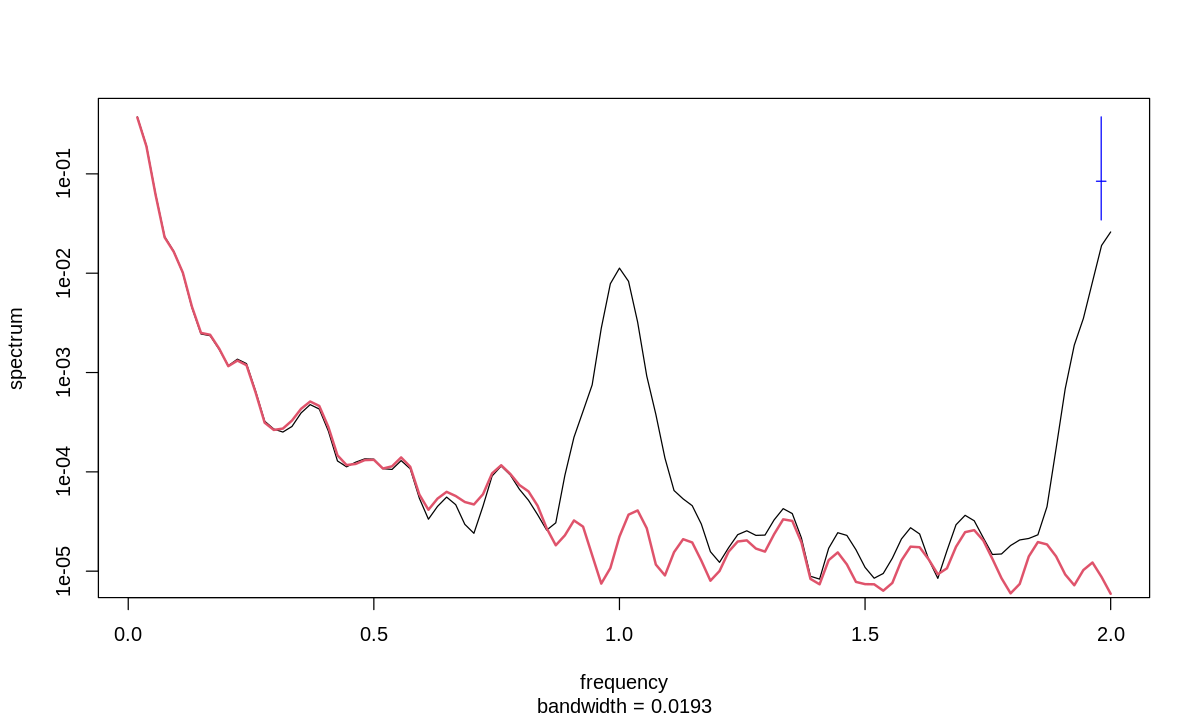

In [38]:
gdp %>% log() %>% spectrum(spans=c(3,3), main="") 
gdp_sa %>% log() %>% spectrum(spans=c(3,3), add=TRUE, col=2, lwd=2) 

### (5) 표본자기상관계수와 표본부분자기상관계수
* 원계열

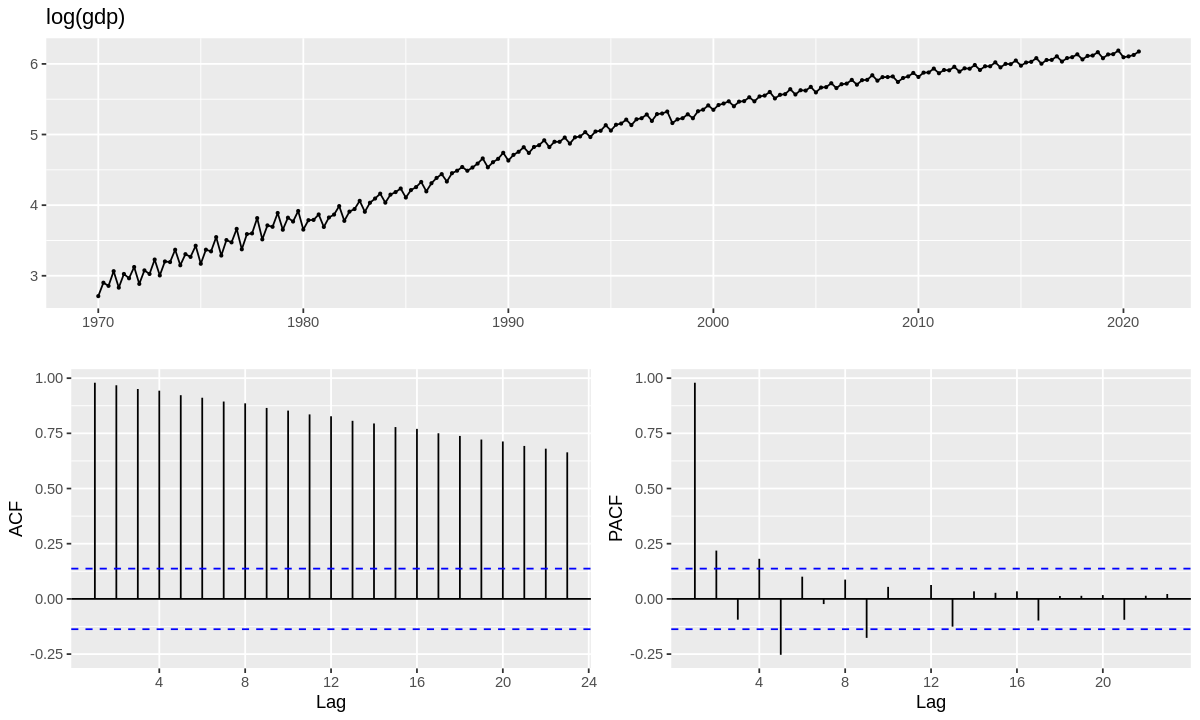

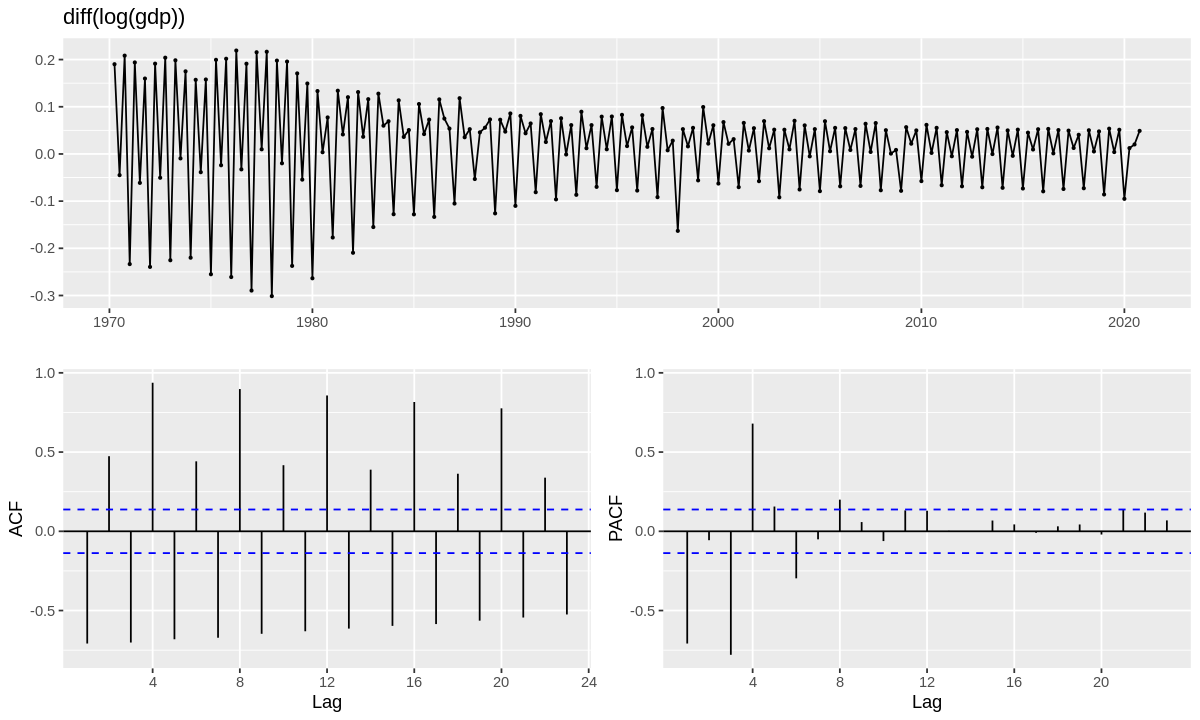

In [49]:
gdp %>% log() %>% ggtsdisplay(main="log(gdp)")
gdp %>% log() %>% diff() %>% ggtsdisplay(main="diff(log(gdp))") 

* 계절조정계열

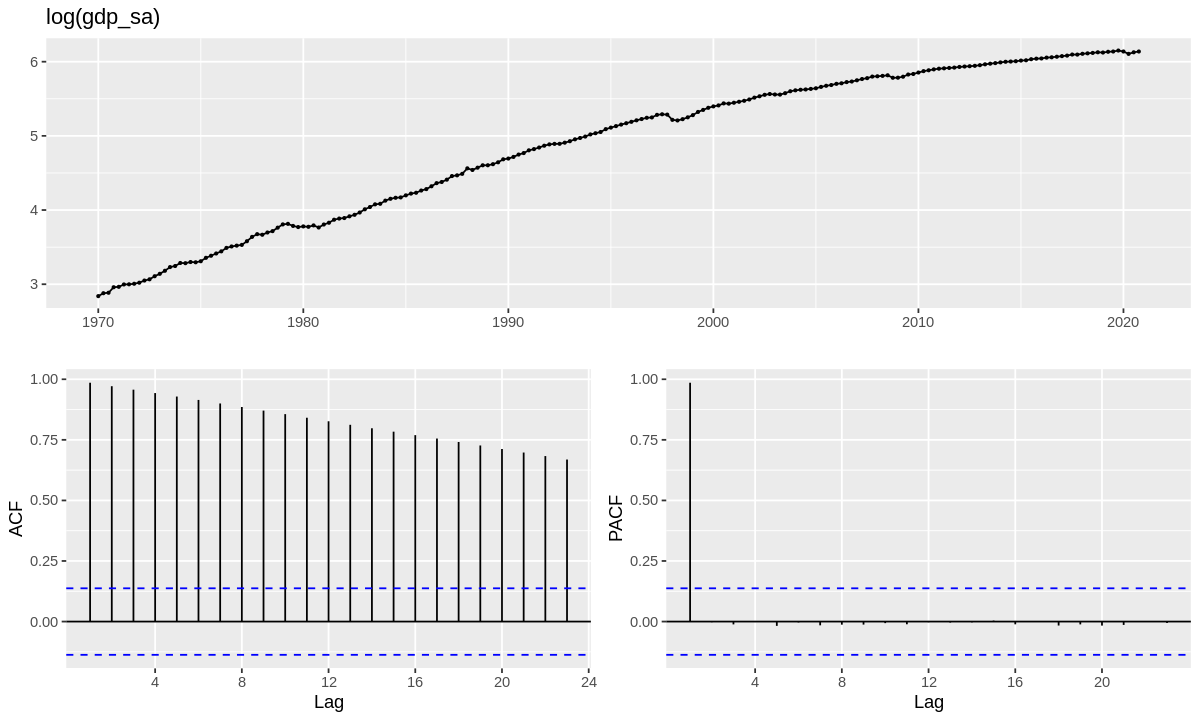

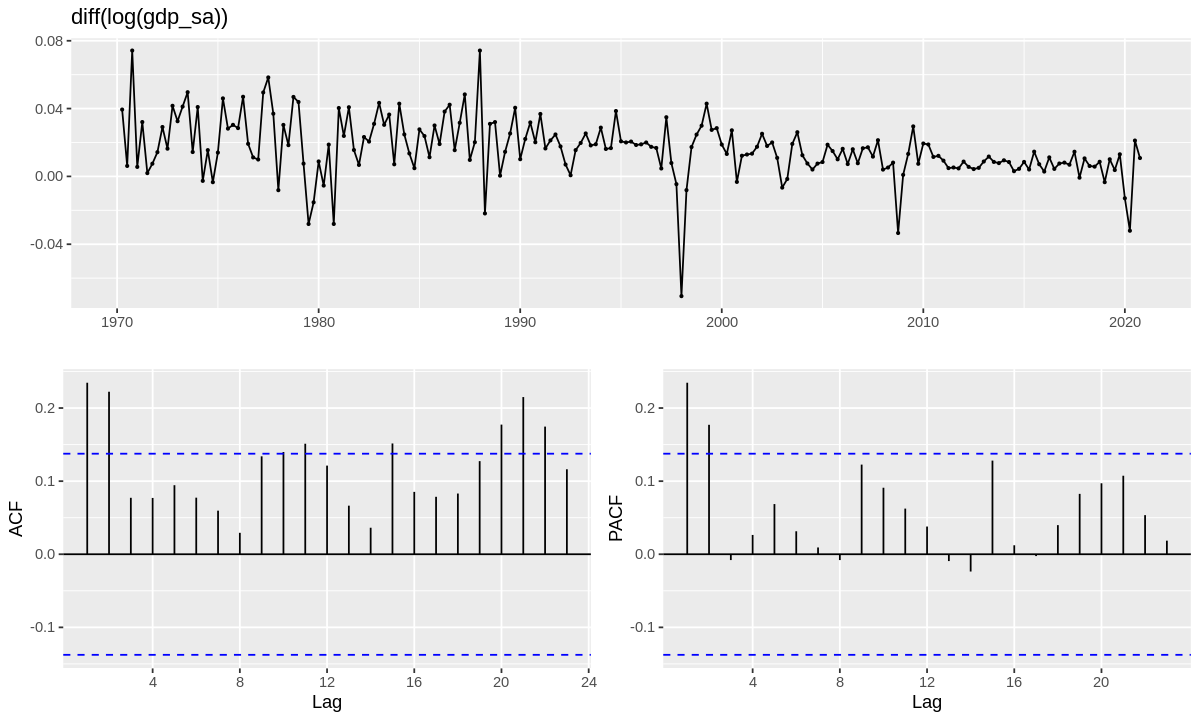

In [50]:
gdp_sa %>% log() %>% ggtsdisplay(main="log(gdp_sa)")
gdp_sa %>% log() %>% diff() %>% ggtsdisplay(main="diff(log(gdp_sa))")

## 5. ARIMA모형

* 시뮬레이션된 데이터와 ACF와 PACF 모습 정리

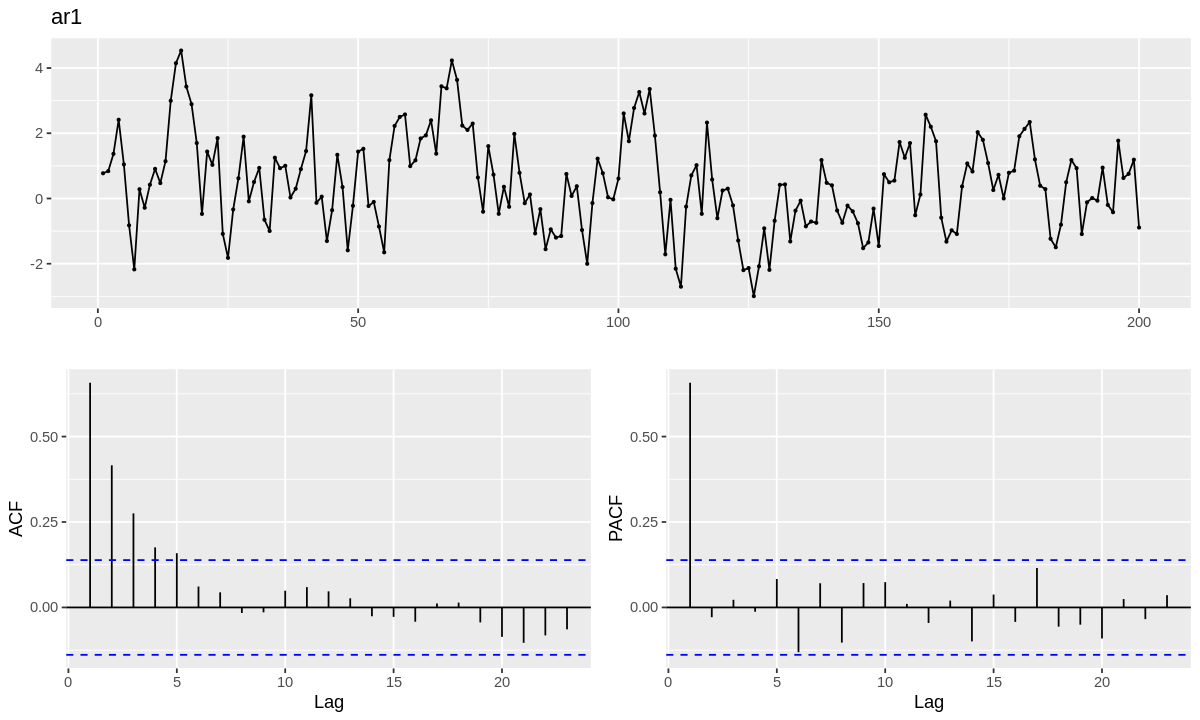

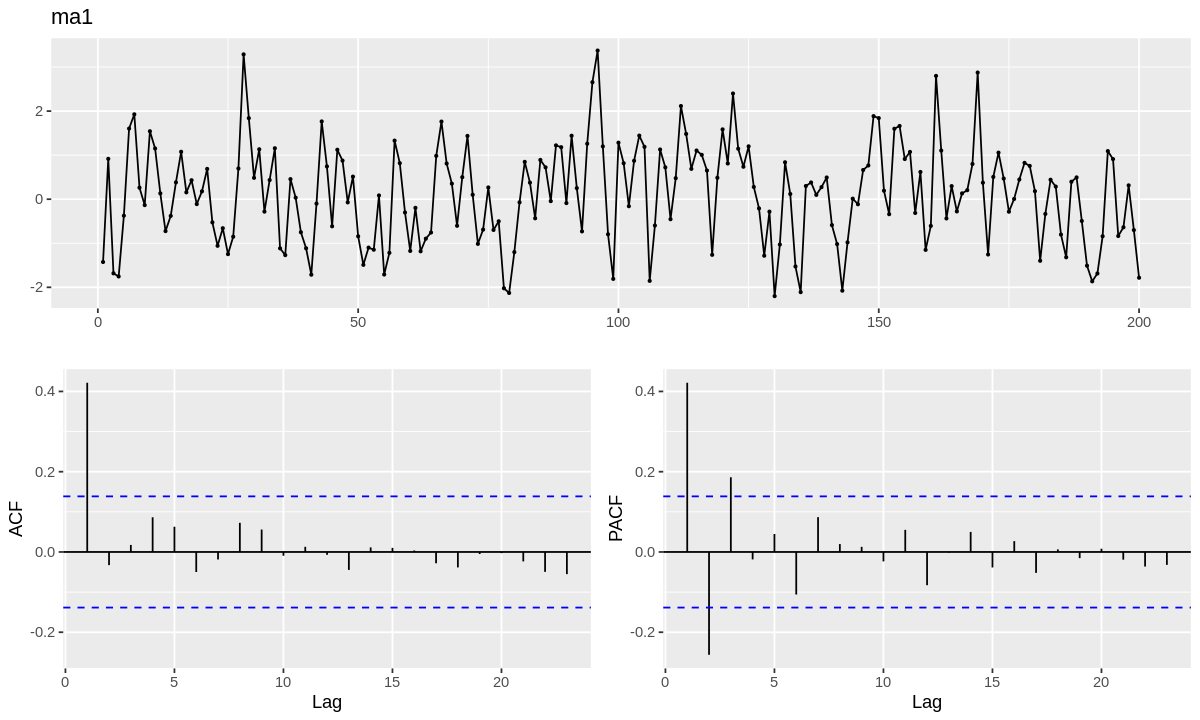

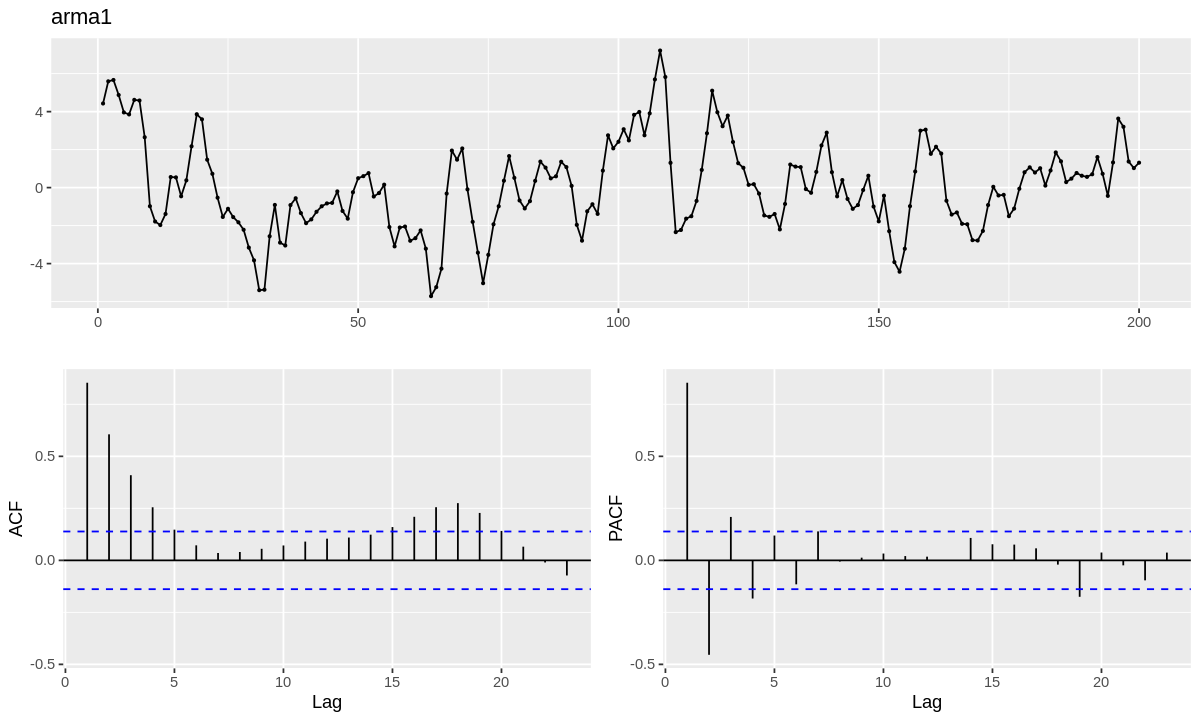

In [9]:
set.seed(12345)
ar1=arima.sim(list(order = c(1,0,0), ar=0.7), n = 200)
ma1=arima.sim(list(order = c(0,0,1), ma=0.7), n = 200)
arma1=arima.sim(list(order = c(1,0,1), ar=0.7, ma=0.7), n = 200)
ar1 %>%  ggtsdisplay(main="ar1")
ma1 %>%  ggtsdisplay(main="ma1")
arma1 %>%  ggtsdisplay(main="arma1")

* ARIMA 모형의 추정

In [76]:
ar1=arima.sim(list(order = c(1,0,1), ar=0.7, ma=0.7), n = 200)
ar1_train =ar1[1:160]
ar1_test  =ar1[161:200]

arima_1 = arima(ar1_train, order=c(1,0,0))
arima_2 = arima(ar1_train, order=c(0,0,1))
arima_3 = arima(ar1_train, order=c(1,0,1))
arima_4 = arima(ar1_train, order=c(2,0,0))
arima_5 = auto.arima(ar1_train)

In [82]:
arima_1
arima_2
arima_3
arima_4
arima_5


Call:
arima(x = ar1_train, order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.7946     0.1525
s.e.  0.0471     0.4045

sigma^2 estimated as 1.156:  log likelihood = -239.15,  aic = 484.29


Call:
arima(x = ar1_train, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.8869     0.1082
s.e.  0.0274     0.1617

sigma^2 estimated as 1.183:  log likelihood = -241.22,  aic = 488.44


Call:
arima(x = ar1_train, order = c(1, 0, 1))

Coefficients:
         ar1     ma1  intercept
      0.6138  0.7412     0.1300
s.e.  0.0658  0.0532     0.3143

sigma^2 estimated as 0.7967:  log likelihood = -209.86,  aic = 427.72


Call:
arima(x = ar1_train, order = c(2, 0, 0))

Coefficients:
         ar1      ar2  intercept
      1.1715  -0.4715     0.1236
s.e.  0.0697   0.0700     0.2488

sigma^2 estimated as 0.8993:  log likelihood = -219.29,  aic = 446.58

Series: ar1_train 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1     ma1
      0.6151  0.7412
s.e.  0.0657  0.0532

sigma^2 estimated as 0.8077:  log likelihood=-209.95
AIC=425.89   AICc=426.05   BIC=435.12

In [83]:
f1 = predict(arima_1, 40)
f2 = predict(arima_2, 40)
f3 = predict(arima_3, 40)
f4 = predict(arima_4, 40)
f5 = predict(arima_5, 40)

In [63]:
install.packages("DMwR")
library(DMwR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘abind’, ‘ROCR’


Loading required package: lattice

Loading required package: grid



In [84]:
acc_1=regr.eval(ar1_test, f1$pred)
acc_2=regr.eval(ar1_test, f2$pred)
acc_3=regr.eval(ar1_test, f3$pred)
acc_4=regr.eval(ar1_test, f4$pred)
acc_5=regr.eval(ar1_test, f5$pred)
acc_all=rbind(acc_1,acc_2,acc_3, acc_4, acc_5)
acc_all

,mae,mse,rmse,mape
acc_1,1.989722,5.877104,2.424274,0.9781738
acc_2,2.143131,6.558367,2.560931,1.0339208
acc_3,2.087666,6.328449,2.515641,1.0172867
acc_4,2.141201,6.585854,2.566292,1.0460214
acc_5,2.184874,6.815018,2.610559,0.9693628


## 6. 경제성장률의 ARIMA 모형 예측

Series: . 
ARIMA(1,1,3) 

Coefficients:
          ar1      ma1      ma2      ma3
      -0.2215  -0.6234  -0.1710  -0.1441
s.e.   0.4496   0.4419   0.3964   0.0771

sigma^2 estimated as 0.0002664:  log likelihood=545.59
AIC=-1081.19   AICc=-1080.88   BIC=-1064.65

Training set error measures:
                       ME       RMSE        MAE       MPE     MAPE      MASE
Training set -0.001955502 0.01611854 0.01097297 -39.81539 150.2222 0.6860575
                    ACF1
Training set -0.01577855

	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)
Q* = 5.8426, df = 4, p-value = 0.2112

Model df: 4.   Total lags used: 8



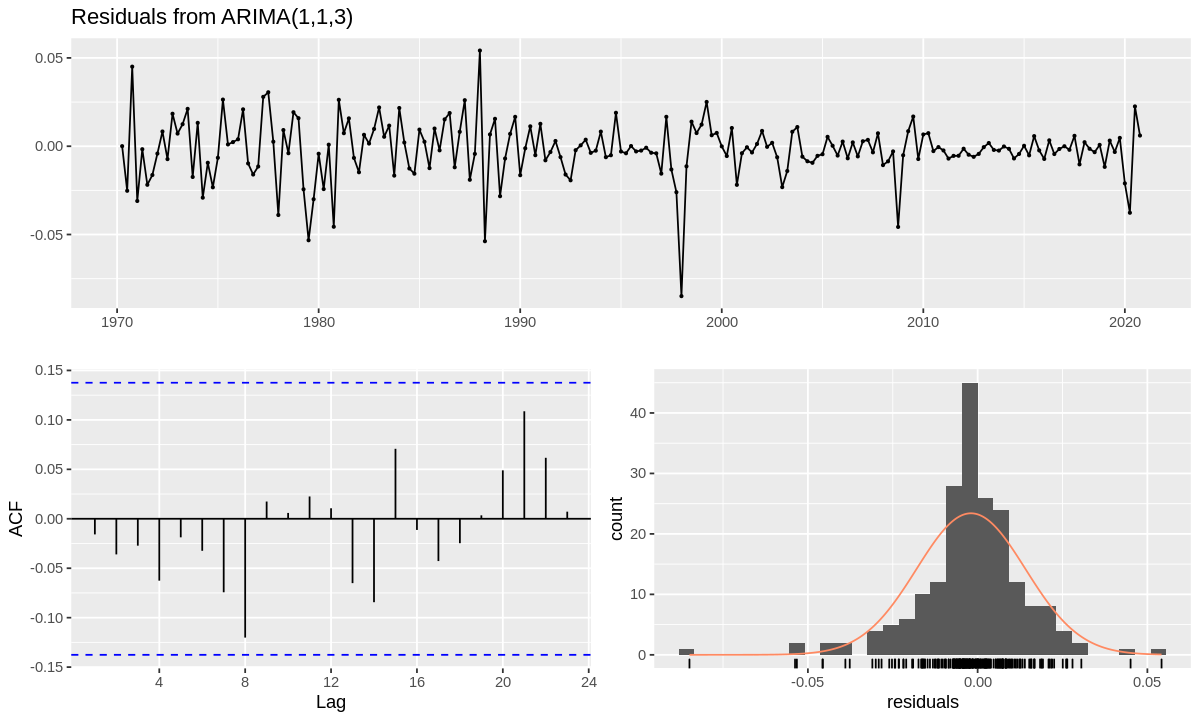

In [45]:
# ARIMA model
arima_model = auto.arima(diff(log(gdp_sa_ts[,3])))

arima_model = gdp_sa_ts[,3] %>% log() %>% diff() %>% auto.arima()
summary(arima_model)
checkresiduals(arima_model)

,Qtr1,Qtr2,Qtr3,Qtr4
2021,0.010917529,0.006615572,0.006697264,0.006679172


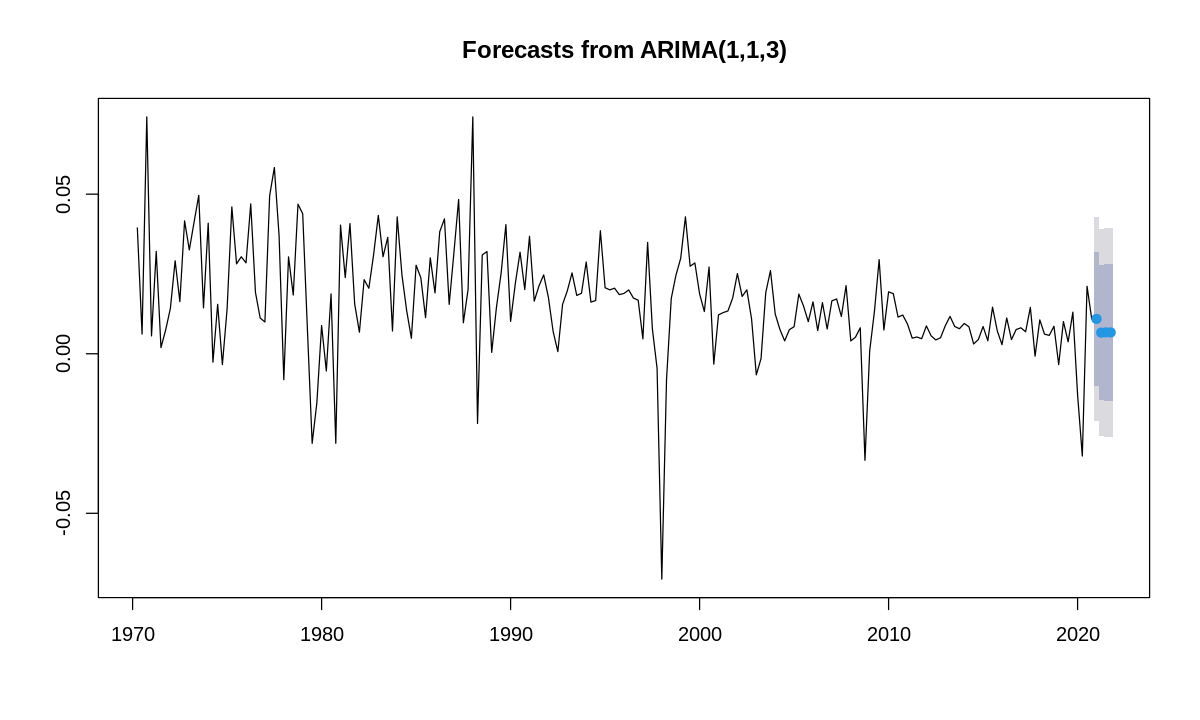

In [48]:
ff = forecast(arima_model, h=4) %>% plot()
ff$mean %>% tail()

## 7. GDP의 분해

In [71]:
install.packages("mFilter")
library(mFilter)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



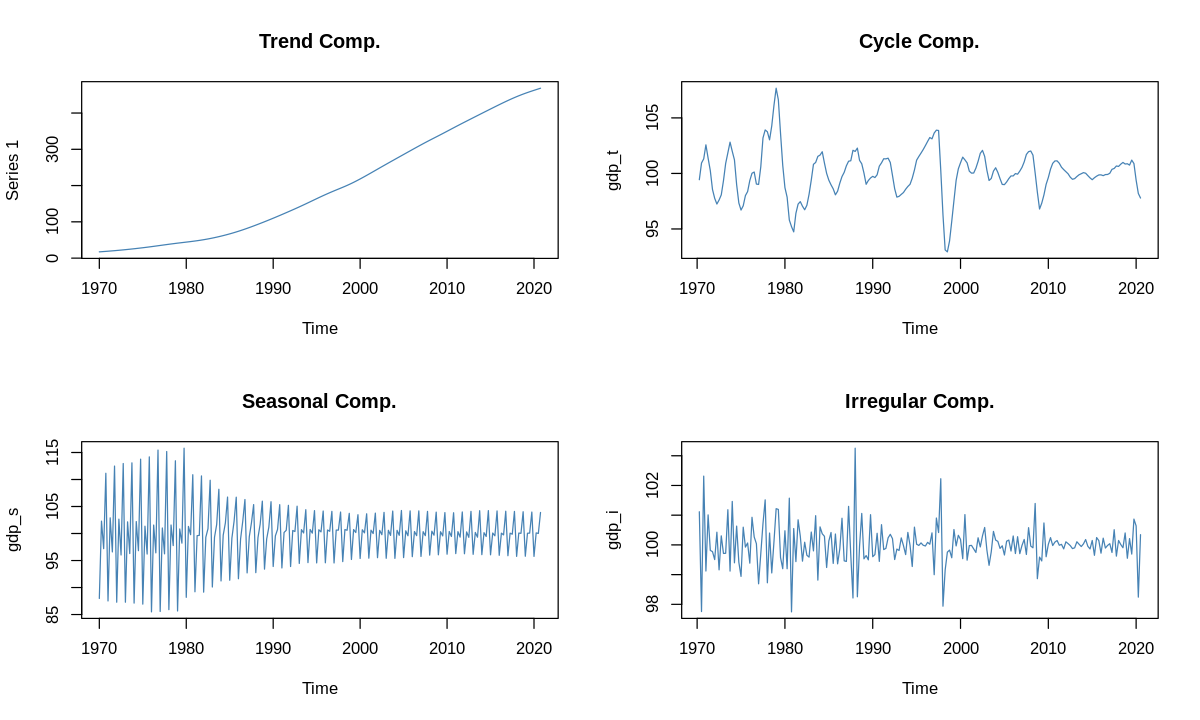

In [74]:
# GDP 변동요인 분해 
 lgdp.hp = mFilter(log(gdp_sa),filter="HP")   # Hodrick-Prescott filter
 gdp_t = exp(lgdp.hp$trend)
 gdpsam = exp((log(gdp_sa)+lag(log(gdp_sa),-1)+lag(log(gdp_sa),1))/3)
 gdp_s = gdp/gdp_sa*100
 gdp_i = gdp_sa/gdpsam*100
 gdp_c = gdpsam/gdp_t*100

 
## Fig 5-2 ##
par(mfrow=c(2,2))
plot(gdp_t, main="Trend Comp.", col="steelblue")
plot(gdp_c, main="Cycle Comp.", col="steelblue")
plot(gdp_s, main="Seasonal Comp.", col="steelblue")
plot(gdp_i, main="Irregular Comp.", col="steelblue")